In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install opendatasets --quiet

import opendatasets as od
import os

od.download('https://www.kaggle.com/datasets/jangedoo/utkface-new')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: t x
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


[age]_[gender]_[race]_[date&time].jpg

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

2

# Import Data

In [ ]:
def extract_age(filename):
    return int(filename.split("_")[0])

In [ ]:
path = '/content/utkface-new/UTKFace/'
image_path = []
image_age = []


for image in os.listdir(path):
  image_path.append(path+image)
  image_age.append(extract_age(image))

In [ ]:
data_df = pd.DataFrame(zip(image_path, image_age), columns = ['image_paths', 'age'])

In [ ]:
data_df.head()

,image_paths,age
0,/content/utkface-new/UTKFace/34_1_3_2017011920...,34
1,/content/utkface-new/UTKFace/75_0_0_2017011120...,75
2,/content/utkface-new/UTKFace/23_1_2_2017011617...,23
3,/content/utkface-new/UTKFace/36_1_0_2017010423...,36
4,/content/utkface-new/UTKFace/22_1_3_2017010422...,22


# Plot age distribution

<Axes: ylabel='Frequency'>

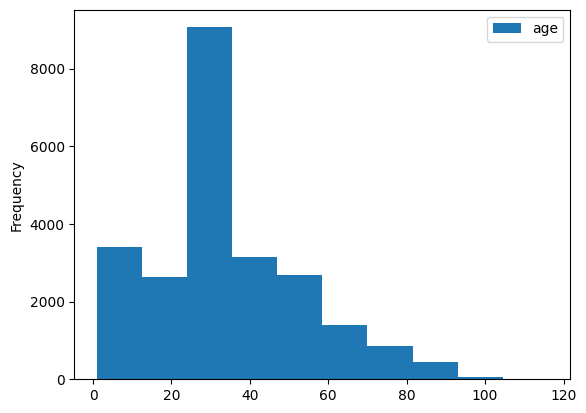

In [ ]:
data_df.plot(kind='hist')

## Age Groups

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, float('inf')]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

data_df['age_group'] = pd.cut(data_df['age'], bins=bins, labels=labels, right=False)

In [ ]:
data_df.head()

,image_paths,age,age_group
0,/content/utkface-new/UTKFace/34_1_3_2017011920...,34,30-39
1,/content/utkface-new/UTKFace/75_0_0_2017011120...,75,70+
2,/content/utkface-new/UTKFace/23_1_2_2017011617...,23,20-29
3,/content/utkface-new/UTKFace/36_1_0_2017010423...,36,30-39
4,/content/utkface-new/UTKFace/22_1_3_2017010422...,22,20-29


# Data pre-processing

## Data splitting

In [ ]:
train_df = data_df.sample(frac=0.8)
test_df = data_df.drop(train_df.index)
val_df = test_df.sample(frac=0.5)
test_df = test_df.drop(val_df.index)

In [ ]:
data_df.shape, train_df.shape, test_df.shape, val_df.shape

((23708, 3), (18966, 3), (2371, 3), (2371, 3))

# Define essetial transformation

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sequential, CrossEntropyLoss, MSELoss, L1Loss
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.RandomCrop(180, padding=10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

## Image Pre-processing

In [ ]:
def preprocess_image(image, gamma=1.5, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert to YCrCb color space for better contrast enhancement
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)

    y_blurred = cv2.medianBlur(y, 5)

    # Apply CLAHE (Adaptive Histogram Equalization) on the Y (luminance) channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    y_clahe = clahe.apply(y_blurred)

    # Merge and convert back to BGR
    enhanced = cv2.merge([y_clahe, cr, cb])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_YCrCb2BGR)

    # Apply Gamma Correction
    inv_gamma = 1.0 / gamma
    gamma_table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    enhanced = cv2.LUT(enhanced, gamma_table)

    # Apply Contrast Stretching
    min_val, max_val, _, _ = cv2.minMaxLoc(cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY))
    stretched = cv2.convertScaleAbs(enhanced, alpha=255.0/(max_val-min_val), beta=-min_val*255.0/(max_val-min_val))

    # Normalize image to range [0, 255]
    normalized = cv2.normalize(stretched, None, 0, 255, cv2.NORM_MINMAX)

    return normalized

## CustomDatasets Pytorch Class

In [ ]:
class customDatasets(Dataset):
  def __init__(self, dataframe, transform=None):
     super().__init__()
     self.dataframe = dataframe
     self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index, 0]
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = torch.tensor(self.dataframe.iloc[index]['age'], dtype=torch.float)

    if self.transform:
      image = self.transform(image)

    return image.to(device), label

## Define DataLoader

In [ ]:
original_train_dataset = customDatasets(train_df, transform=transformer)
augmented_train_dataset = customDatasets(train_df, transform=transform_augmented)
test_dataset = customDatasets(test_df, transform=transformer)
val_dataset = customDatasets(val_df, transform=transformer)

In [ ]:
train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset])

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

(3, 200, 200)
(200, 200, 3)


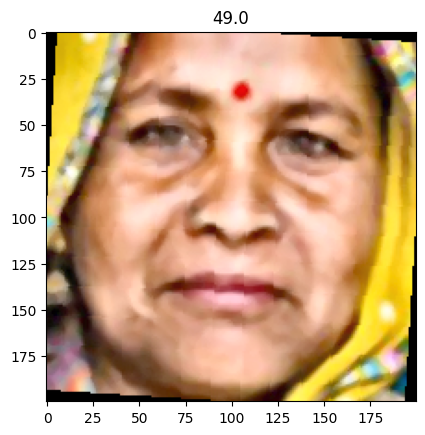

In [ ]:
images, labels = next(iter(train_dataloader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

for i in range(len(images)):
    print(images[i].shape)
    image = images[i].transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.show()
    break

# Face Age Prediction Model

## Neural network modeling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FAPNet(nn.Module):
    def __init__(self, output_dim=1):
        super(FAPNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * 12 * 12, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.output = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        return self.output(x)

In [ ]:
model = FAPNet().to(device)

## Detailed vue of model layers and parameters

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]           2,432
       BatchNorm2d-2         [-1, 32, 200, 200]              64
              ReLU-3         [-1, 32, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           9,248
       BatchNorm2d-5         [-1, 32, 200, 200]              64
              ReLU-6         [-1, 32, 200, 200]               0
         MaxPool2d-7         [-1, 32, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          51,264
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
           Conv2d-11         [-1, 64, 100, 100]          36,928
      BatchNorm2d-12         [-1, 64, 100, 100]             128
             ReLU-13         [-1, 64, 100, 100]               0
        MaxPool2d-14           [-1, 64,

## Define **Cost function** and **Optimization algorithm**

In [ ]:
LR = 5e-3
EPOCHS = 20

In [ ]:
criterion = L1Loss()
optimizer = Adam(model.parameters(), lr=LR,)

## Model training

In [ ]:
total_loss_train_plot = []
total_loss_test_plot = []

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # outputs = model(inputs)
        outputs = model(inputs).squeeze(1)

        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # outputs = model(inputs)
            outputs = model(inputs).squeeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(test_dataloader)

    total_loss_train_plot.append(avg_train_loss)
    total_loss_test_plot.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss (MAE): {avg_train_loss:.4f}")
    print(f"Val Loss (MAE):   {avg_val_loss:.4f}")
    print("=" * 50)

Epoch 1/20
Train Loss (MAE): 11.8561
Val Loss (MAE):   10.2253
Epoch 2/20
Train Loss (MAE): 7.9322
Val Loss (MAE):   7.4495
Epoch 3/20
Train Loss (MAE): 7.3342
Val Loss (MAE):   6.4955
Epoch 4/20
Train Loss (MAE): 6.9315
Val Loss (MAE):   6.2511
Epoch 5/20
Train Loss (MAE): 6.6594
Val Loss (MAE):   6.6024
Epoch 6/20
Train Loss (MAE): 6.4904
Val Loss (MAE):   5.9080
Epoch 7/20
Train Loss (MAE): 6.3169
Val Loss (MAE):   5.5690
Epoch 8/20
Train Loss (MAE): 6.1222
Val Loss (MAE):   5.8350
Epoch 9/20
Train Loss (MAE): 6.0179
Val Loss (MAE):   5.6191
Epoch 10/20
Train Loss (MAE): 5.8545
Val Loss (MAE):   5.6298
Epoch 11/20
Train Loss (MAE): 5.7542
Val Loss (MAE):   6.0492
Epoch 12/20
Train Loss (MAE): 5.6994
Val Loss (MAE):   5.5661
Epoch 13/20
Train Loss (MAE): 5.5725
Val Loss (MAE):   5.3836
Epoch 14/20
Train Loss (MAE): 5.4483
Val Loss (MAE):   5.1816
Epoch 15/20
Train Loss (MAE): 5.4053
Val Loss (MAE):   5.4330
Epoch 16/20
Train Loss (MAE): 5.3146
Val Loss (MAE):   5.1916
Epoch 17/20
Tra

## Plotting the training and devolpment mae

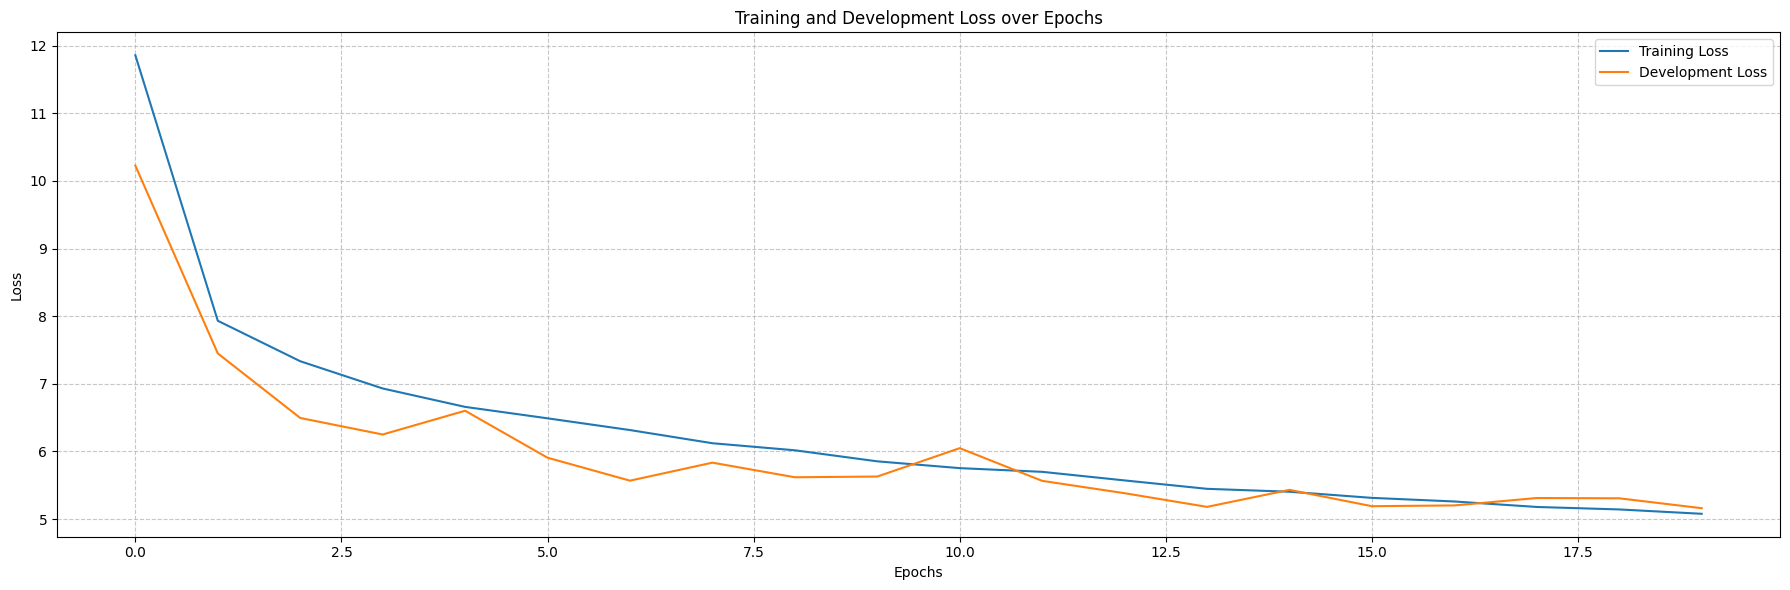

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(total_loss_train_plot, label='Training Loss')
plt.plot(total_loss_test_plot, label='Development Loss')
plt.title('Training and Development Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Validating our model in test dataset

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
predictions = []
true_labels = []

for index in range(len(val_dataset.dataframe)):
    image, label = val_dataset.__getitem__(index)

    image = image.unsqueeze(0).to(device)
    label = label.to(device)

    prediction = model(image).squeeze()

    # Store the prediction and label
    predictions.append(np.round(prediction.item()))
    true_labels.append(np.round(label.item()))

predictions = np.array(predictions)
true_labels = np.array(true_labels)

In [ ]:
mae_age_prediction = mean_absolute_error(true_labels, predictions)
error_percentage = mean_absolute_percentage_error(true_labels, predictions)

In [ ]:
print(f'mean absolute error is: {np.round(mae_age_prediction)}')
print(f'overall error in test dataset: {error_percentage}%')

mean absolute error is: 5.0
overall error in test dataset: 0.24988371082221444%


# Save our best model

In [ ]:
import joblib

file_name = 'human_age_prediction_challenger'
joblib.dump(model, file_name)

['human_age_prediction_challenger']